# Classify ACM Dataset

This notebook assigns a class label to each of our competitions.

## Approach 1: Topic Modeling on Competition Proposals

In [26]:
import pandas as pd

### Part 1: Select any "jugements"

In [27]:
competitions = pd.read_feather("Data/ACM/AcmEPFL_paired.feather")

In [28]:
jugements = competitions[competitions['is_jury']]

In [29]:
jugements

,orig_index,Nom de l'objet,Programme,Adresse 1,Adresse 2,Adresse 3,Numéro postal,Localité,Canton - Département,Pays,...,Concours ouvert à,Notes de l'objet,Auteurs,Rôle de l'auteur,Dossiers reliés,Pièces reliées,CombinedArtists,is_jury,paired_competitons,comp_id
1,1,Concours pour le nouveau bâtiment des écoles d...,None,None,None,None,NaN,Vevey,None,Vaud,...,None,Le concours est mentionné en 1878 (Eisenbahn v...,"Stadler +;Ritscher von Steinbeck +;Recordon, B...","3e prix;3e prix;Juré, rapporteur;Concurrent;2e...",None,None,"[[Stadler, Ritscher von Steinbeck, Recordon, B...",True,[0],1
3,3,Concours restreint pour le nouveau Musée de la...,None,None,None,None,NaN,Mulhouse,None,None,...,None,"""Par suite d'un concours entre un nombre restr...","Rütti, Ludwig Friedrich von",Concurrent,None,None,"[[Rütti, Ludwig Friedrich von]]",True,[],3
6,6,"Concours pour l'usine de la Coulouvrenière, à ...",None,Coulouvrenière,None,None,NaN,Genève,None,Genève,...,None,Pas d'extrait de rapport du jury dans la SBZ. ...,Turnbull;Bell & Cie;Escher Wyss & Cie;Rieter &...,Concurrent;Concurrent;Concurrent;Concurrent,None,None,"[[Turnbull], [Bell & Cie], [Escher Wyss & Cie]...",True,[976],6
10,10,"Concours pour une école d'horlogerie au Locle,...",None,None,None,None,NaN,Le Locle,None,Suisse,...,None,Pas d'extrait de rapport du jury dans la SBZ. ...,"Colin, James Edouard;Ritter +;Piquet, Edouard-...",1er prix;3e prix;3e prix;1er prix,None,None,"[[Colin, James Edouard], [Ritter, Piquet, Edou...",True,[9],10
12,12,Concours restreint pour un bâtiment des salles...,None,None,None,None,NaN,Neuchâtel,None,Suisse,...,None,Pas d'extrait de rapport du jury (il n'a d'ail...,"Colin, James Edouard;Mayor, William;Rychner, A...",1er prix;2e prix ex aequo;2e prix ex aequo,None,None,"[[Colin, James Edouard], [Mayor, William], [Ry...",True,[11],12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2294,2294,Concours pour le nouveau cimetière du Bois de ...,None,None,None,None,NaN,Lausanne,None,Vaud,...,None,None,None,None,None,None,None,True,[],2294
2298,2298,"Concours pour le viaduc de la Gryonne, jugement",None,None,None,None,NaN,Gryon,None,Vaud,...,None,"Trois projets présentés avec trois offres ""don...",Ateliers de constructions mécaniques de Vevey ...,6e prix,None,None,[[Ateliers de constructions mécaniques de Veve...,True,[47],2298
2342,2342,Concours pour une salle d'attente de tramways ...,None,Place de Purry,None,None,NaN,Neuchâtel,None,Neuchâtel,...,None,Onze projets reçus. Concours ouvert par la Soc...,"Fath, Georges +;Matthey, Henri +;Yonner, Eugèn...",4e prix;4e prix;3e prix;3e prix;2e prix ex aeq...,None,None,"[[Fath, Georges, Matthey, Henri, Yonner, Eugèn...",True,[],2342
2345,2345,Concours restreint pour une patinoire artifici...,None,None,None,None,NaN,None,None,None,...,None,None,None,None,None,None,None,True,[],2345


In [30]:
jugements['Nom de l\'objet'].iloc[7]

"Concours pour un bâtiment scolaire et d'administration, jugement"

In [31]:
# Some duplicate jugements . . . keep the one with more info.
jugements = jugements.sort_values(by='Notes de l\'objet', key=lambda x: x.str.len(), ascending=False)
jugements = jugements.drop_duplicates(subset='Nom de l\'objet', keep='first')


In [32]:
jugements.drop(columns="CombinedArtists").to_csv("jugements_no_duplicates.csv", index=False)

In [33]:
texts = jugements['Nom de l\'objet'].dropna().to_list()

In [34]:
texts

["Concours d'architecture pour l'édification d'un palais de la Société des Nation, jugement",
 'Concours pour le palais de la Société des nations, à Genève, jugement',
 'Concours/ attribution de prix et diplômes aux meilleures façades genevoises, jugement',
 'Concours de projet pour la reconstitution du Pont du Mont-Blanc à Genève, jugement',
 'Concours des ponts de Lausanne, jugement',
 "Concours pour les plans de l'édifice de Rumine , jugement",
 "Concours pour une Caserne d'Infanterie à Lausanne, jugement",
 "Concours pour l'Hôtel des postes et des télégraphes, à Aarau, jugement",
 "Concours pour l'exécution du pont Chauderon-Montbenon, jugement",
 "Concours international d'idées pour un plan d'extension de la ville et des faubourgs de Zürich, jugement",
 'Concours pour le Musée des Beaux-Arts, à Bâle (Elisabethenschanze), jugement',
 "Concours d'idées pour une école supérieure de jeunes filles, à Genève, jugement",
 'Concours/ attribution de diplômes aux meilleures constructions (1

In [35]:
with open('CompetitionNames.txt', 'w') as f:
    for name in texts:
        f.write(f"{name}\n")

## Part 2: Statistics on lemmas

In [36]:
import spacy
from bertopic import BERTopic
from tqdm import tqdm
import collections
import itertools
import matplotlib.pyplot as plt

In [37]:
nlp = spacy.load("fr_dep_news_trf")


### 1. Keyword (lemma) frequencies – stop‑words & punctuation removed

In [38]:
spacy_docs = nlp.pipe(texts)

# concours             796
# jugement             779
# bâtiment             122
# lausanne             93
# genève               74
# aménagement          70
# idée                 65

concours_stopwords = ["degré", "berne", "fribourg", "projet", "concours", "jugement", "bâtiment", "lausanne", "genève", "aménagement", "idée", "neuchâtel", "construction"] 

keyword_counter   = collections.Counter()
bigram_counter    = collections.Counter()
cooccurrence_raw  = collections.Counter()   # pair → count

for doc in spacy_docs:
    lemmas = [
        tok.lemma_.lower()
        for tok in doc
        if not tok.is_stop and not tok.is_punct and tok.pos_ in {"NOUN", "ADJ"} and tok.lemma_ != "" and tok.lemma_.lower() not in concours_stopwords
    ]
    
    # --- 1a. keyword counts
    keyword_counter.update(lemmas)
    
    # --- 1b. bigram counts  (adjacent non‑stopword lemmas)
    bigram_counter.update(zip(lemmas, lemmas[1:]))
    
    # --- 1c. co‑occurrence counts (unordered pairs in same title)
    #       – use *unique* lemmas so duplicates in one title don’t explode counts
    for w1, w2 in itertools.combinations(sorted(set(lemmas)), 2):
        cooccurrence_raw[(w1, w2)] += 1


### Inspect Results

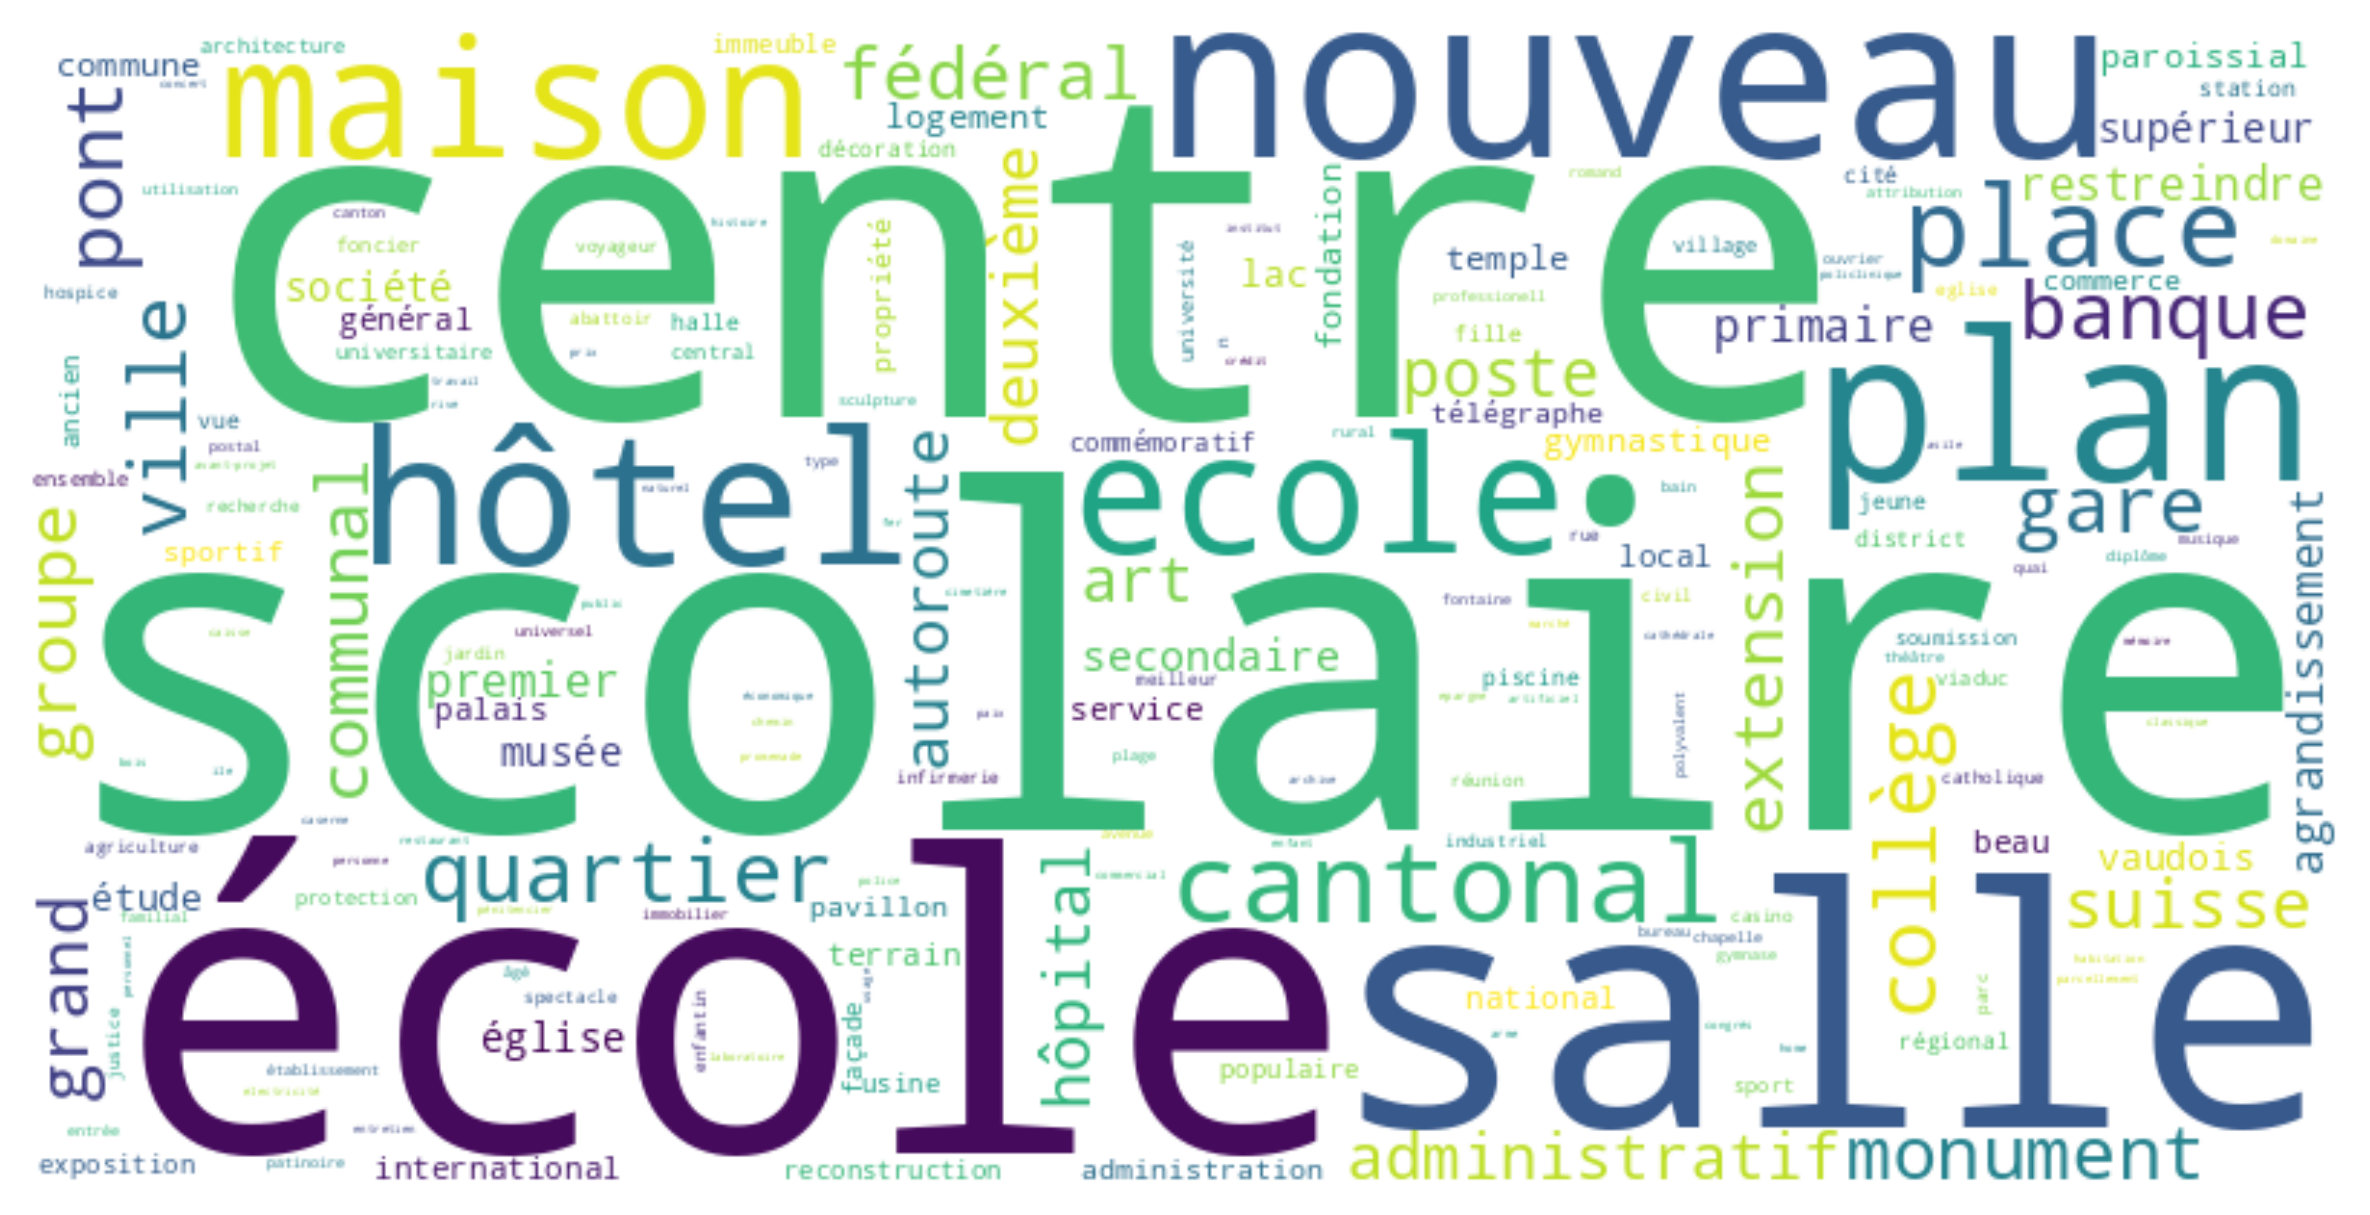


Top words:
scolaire                  64
centre                    61
école                     49
salle                     44
nouveau                   40
plan                      33
hôtel                     33
maison                    30
ecole                     30
cantonal                  28
place                     27
quartier                  27
collège                   26
pont                      24
ville                     24
gare                      24
banque                    24
monument                  21
fédéral                   20
communal                  20
groupe                    20
extension                 19
grand                     19
suisse                    19
poste                     18
art                       16
hôpital                   16
administratif             16
deuxième                  16
autoroute                 16
restreindre               16
premier                   15
primaire                  15
agrandissement            15
se

In [39]:
from wordcloud import WordCloud

TOP_N = 100
import matplotlib.pyplot as plt

# Generate a word cloud from the keyword_counter
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(keyword_counter)

# Display the word cloud
plt.figure(figsize=(10, 5), dpi=300)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

print("\nTop words:")
for big, freq in keyword_counter.most_common(TOP_N):
    print(f"{big:25s} {freq}")

print("\nTop bigrams:")
for big, freq in bigram_counter.most_common(TOP_N):
    print(f"{' '.join(big):25s} {freq}")


In [40]:
K = 15
top_k_terms   = [w for w, _ in keyword_counter.most_common(K)]
pair_to_freq  = {(w1, w2): cooccurrence_raw.get(tuple(sorted((w1, w2))), 0)
                 for w1 in top_k_terms for w2 in top_k_terms}

cooc_df = (
    pd.Series(pair_to_freq)
      .unstack()
      .fillna(0)
      .astype(int)
)

cooc_df.head()          # a K×K matrix you can visualise as heat‑map

,cantonal,centre,collège,ecole,hôtel,maison,nouveau,place,plan,pont,quartier,salle,scolaire,ville,école
cantonal,0,1,0,5,2,0,1,0,2,0,1,0,2,0,2
centre,1,0,0,0,0,0,1,0,0,0,2,1,20,0,0
collège,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ecole,5,0,0,0,0,0,2,0,0,0,1,0,0,2,1
hôtel,2,0,0,0,0,0,5,1,1,1,0,0,0,6,0


In [41]:
import seaborn as sns

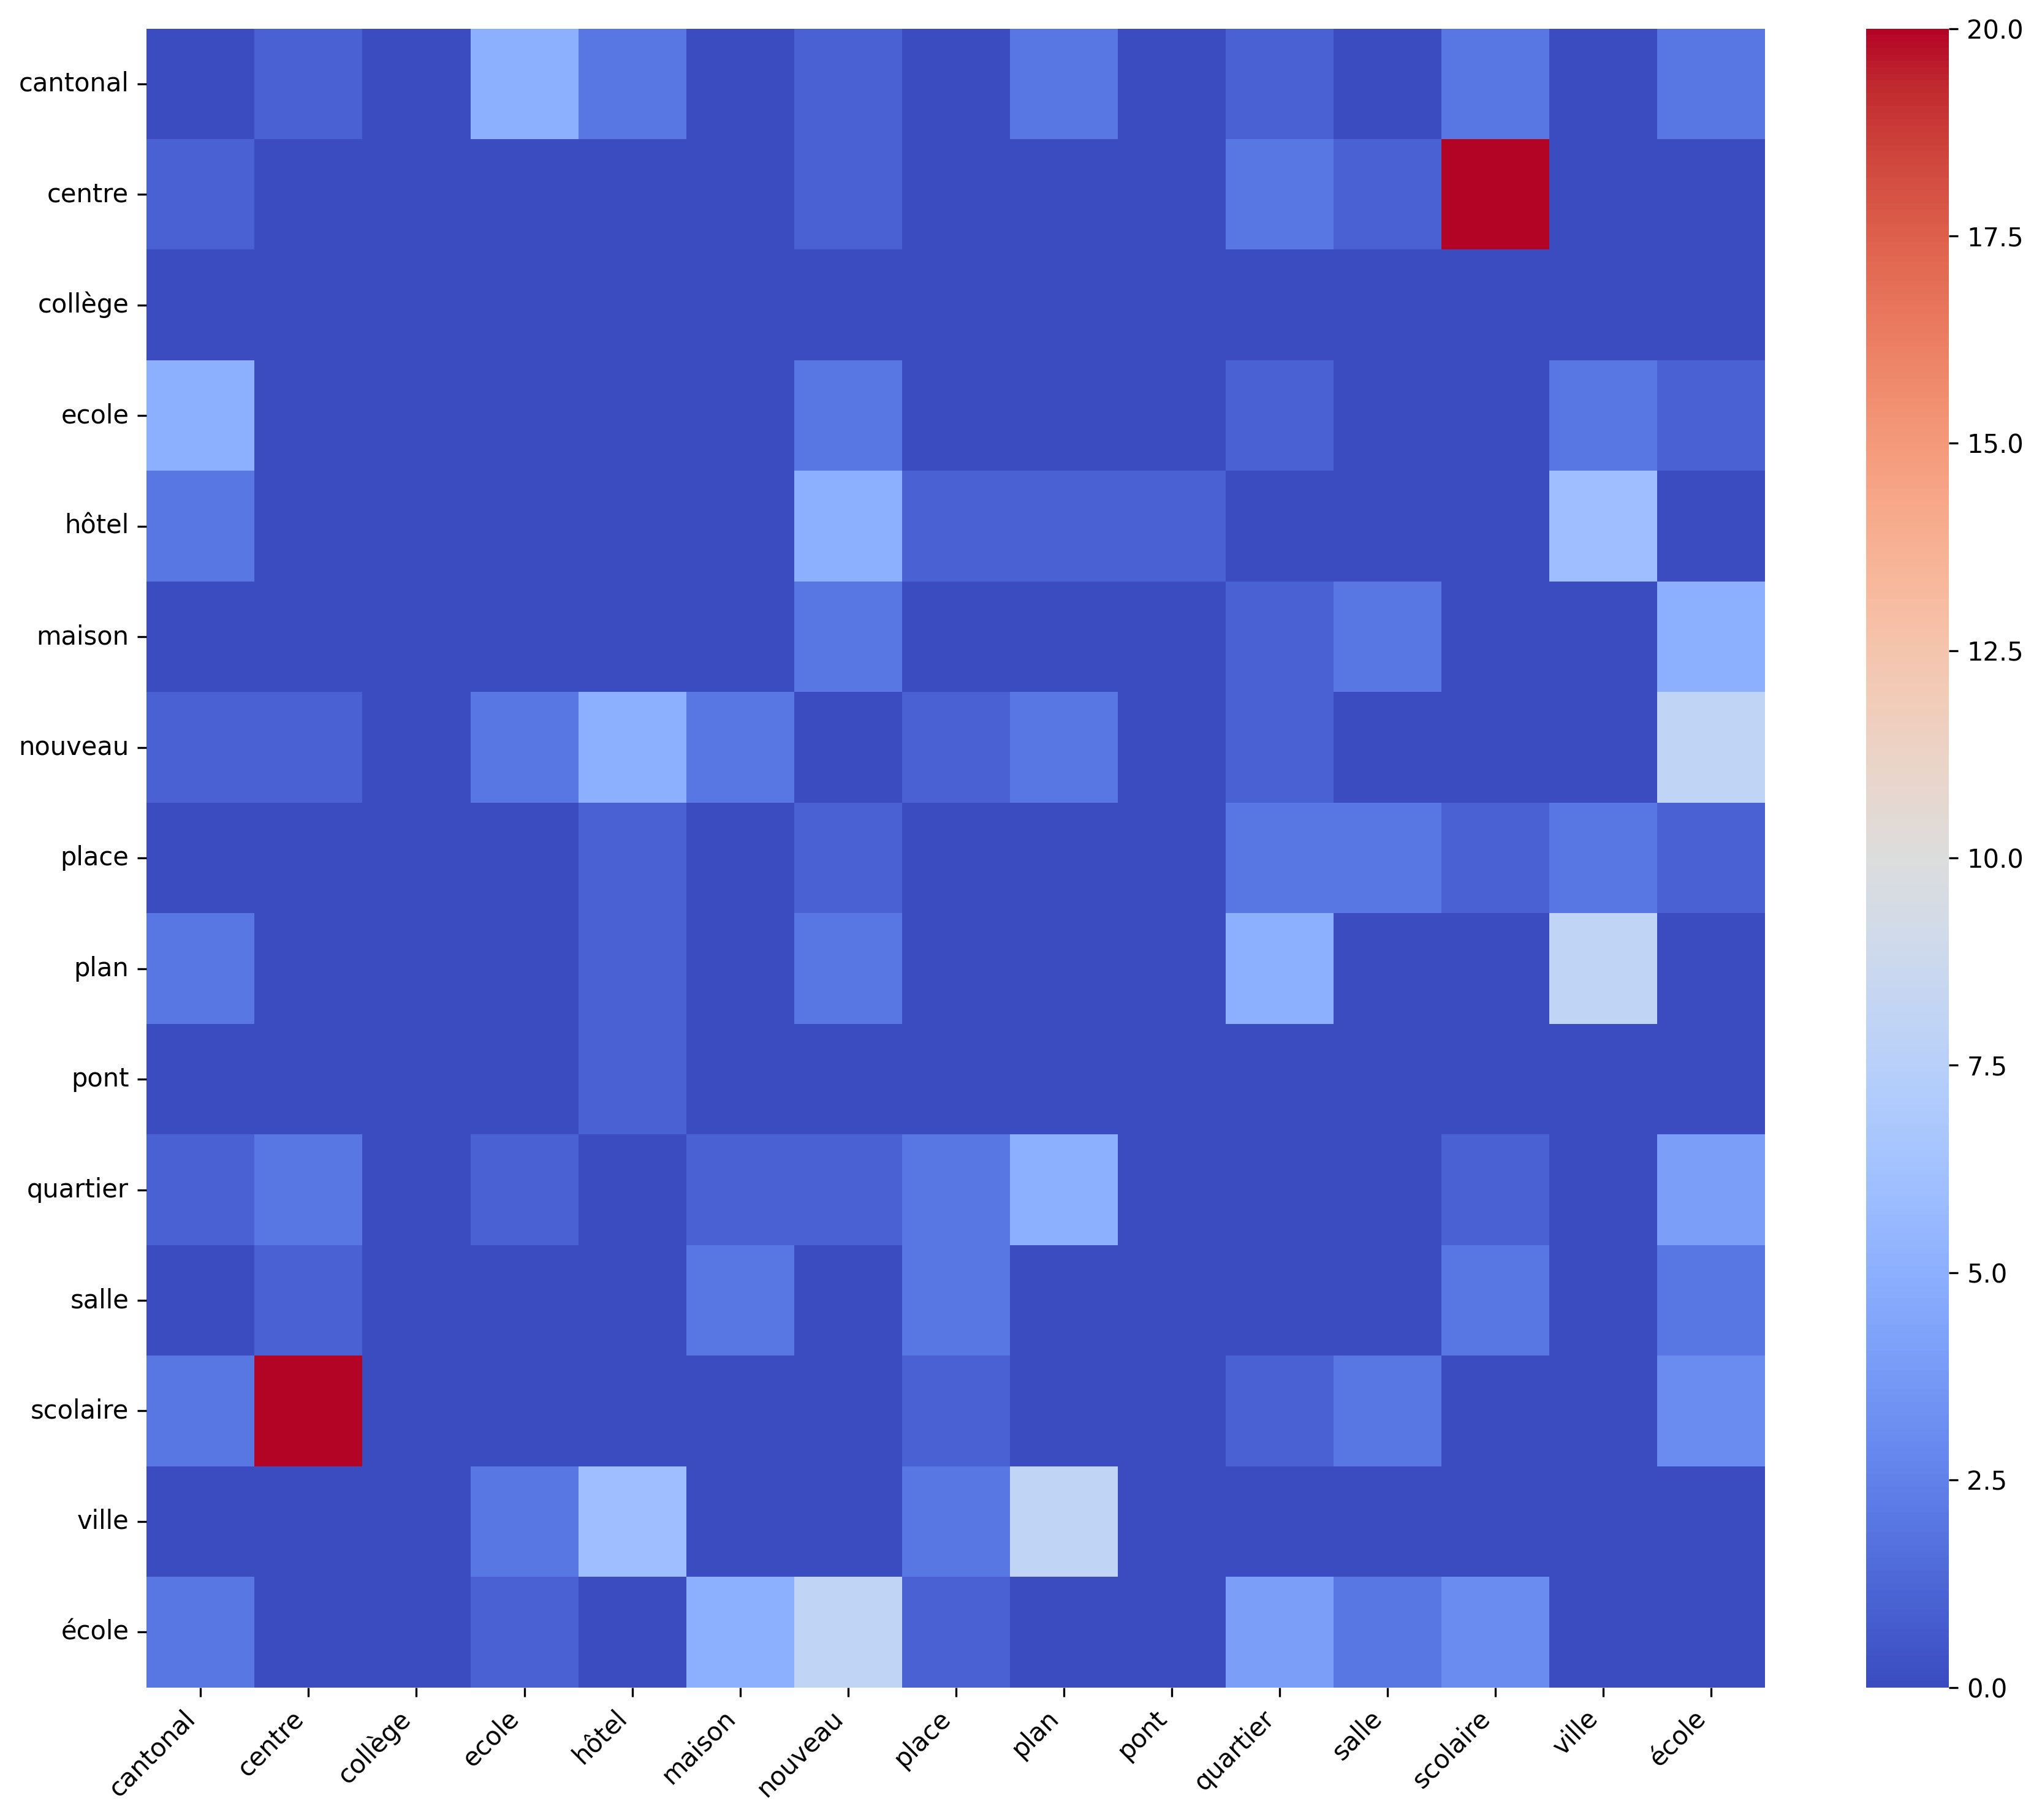

In [42]:
plt.figure(figsize=(12, 10), dpi=300)  # Set high DPI and adjust figure size
sns.heatmap(cooc_df, annot=False, fmt="d", cmap="coolwarm", cbar=True)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.yticks(rotation=0)  # Keep y-axis labels horizontal
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

In [43]:
pmi = cooc_df / (cooc_df.sum(1).values[:,None] * cooc_df.sum(0).values[None,:])

<Axes: >

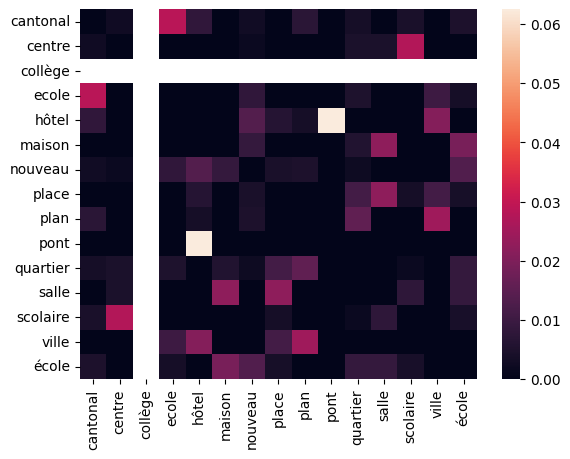

In [44]:
sns.heatmap(pmi)

## Part 3: Use the Keywords

In [45]:
domain_keywords = {
    "Education": {
        "garderie",
        "classe",
        "école",
        "ecole",
        "collège",
        "scolaire",
        "archive",
        "laboratoire",
        "primaire",
        "secondaire",
        "supérieur",
        "université",
        "universitaire",
        "bibliothèque",
        "epfl",
        "recherche",
        "génie",
    },
    "Public / Civic": {
        "centre",
        "salle",
        "congrès",
        "postal",
        "police",
        "administratif",
        "électoral",
        "cantonal",
        "poste",
        "banque",
        "public",
        "justice",
        "administration",
        "district",
        "tribunal",
        "nation",
        "caserne",
        "pénitentiaire",
        "communal",
        "pénitencier",
        "antiaérien",
        "antiaérien" "voyageur",
        "parlement",
        "fédéral",
        "halle",
        "véhicule",
    },
    "Health": {
        "hôpital",
        "crèche",
        "hypothécaire",
        "epargne",
        "cimetière",
        "bürgerspital",
        "infirmerie",
        "vétérinaire",
        "crématoire",
        "âgé",
        "hopital",
        "médico-social",
        "aveugles",
        "âgés",
        "hospice",
        "pédiatrie",
        "maternité",
    },
    "Urban Planning": {
        "plan",
        "nord",
        "quartier",
        "extension",
        "ville",
        "place",
        "terrain",
        "village",
        "cité",
    },
    "Infrastructure": {
        "pont",
        "bateau",
        "canal",
        "pont-route",
        "vue",
        "autoroutier",
        "passerelle",
        "viaduc",
        "voie",
        "tunnel",
        "autoroute",
        "gare",
        "tramway",
        "station",
        "télégraphe",
        "fortification",
        "avion",
        "hangar",
    },
    "Residential": {
        "logement",
        "cuisine",
        "voyageur",
        "villa",
        "habitat",
        "immeuble",
        "pavillon",
        "maison",
        "home",
        "domaine",
        "habitation",
        "mobilier",
        "corporatif"
    },
    "Cultural / Art": {
        "musée",
        "théâtre",
        "façade",
        "exposition",
        "art",
        "palais",
        "musique",
        "conservatoire",
        "muséum",
        "ancien",
        "histoire",
        "sculpture",
        "bas",
        "relief",
        "décoration",
        "vignette",
        "monument",
        "fontaine",
    },
    "Religious": {
        "église",
        "eglise",
        "synagoge",
        "synagogue",
        "temple",
        "paroissial",
        "evêché",
        "chapelle",
    },
    "Sports & Leisure": {
        "gymnastique",
        "bain",
        "sportif",
        "cessnov",
        "piscine",
        "olympie",
        "patinoire",
        "casino",
        "vacance",
        "athlétisme"
    },
    "Landscape": {"lac", "parc", "plage", "jardin"},
    "Corporate / Foundation": {
        "société",
        "compagnie",
        "fondation",
        "commerce",
        "usine",
        "abattoir",
        "agence",
        "comité",
        "werkhof",
        "bourse",
        "mobilier",
        "bureau",
        "corporatif",
        "murtenhof",
        "complexe",
        "institut",
        "marché",
        "ferme",
        "crédit",
        "foire",
    },
    "Other": {
        "attribution",
        "reconstruction",
        "diplôme",
        "construction",
        "salle",
        "captivité",
        "édifice",
        "hôtel",
        "aménagement",
        "service",
        "agrandissement",
    },
}

domain_weights = {
    "Education": 1,
    "Public / Civic": 1.5,
    "Health": 2,
    "Urban Planning": 1,
    "Infrastructure": 1,
    "Residential": 1.1,
    "Cultural / Art": 3,
    "Religious": 3,
    "Sports & Leisure": 2,
    "Landscape": 1,
    "Corporate / Foundation": 1,
    "Other": 0.1,
}

In [46]:
def assign_domain(term_list):
    domain_scores = {}

    for domain, keywords in domain_keywords.items():
        weight = domain_weights[domain]
        matches = [term for term in term_list if term in keywords]
        if matches:
            domain_scores[domain] = len(matches) * weight

    if domain_scores:
        # Pick the domain with the highest (weighted) match count
        return max(domain_scores, key=domain_scores.get)

    return None



In [47]:
import re
def extract_terms(text):
    """
    Return a list of lemmatized NOUN/ADJ tokens (lower‑cased)
    with stop‑words / punctuation removed.
    """
    doc = nlp(str(text))
    return [
        tok.lemma_.lower()
        for tok in doc
        if tok.pos_ in {"NOUN", "ADJ", "PROPN"}
        and not tok.is_stop
        and not tok.is_punct
        and tok.lemma_.strip() != ""
    ]
# Apply extraction to all rows
jugements["extracted_terms"] = jugements["Nom de l'objet"].dropna().apply(extract_terms)

In [48]:
jugements["Domain"] = jugements["extracted_terms"].apply(assign_domain)
for _, row in jugements[jugements['Domain'].isnull()].iterrows():
    print(row['Nom de l\'objet'])
    print(row['extracted_terms'])
    print('\n')

In [49]:
review_df = jugements[["Nom de l'objet", "Domain", "extracted_terms"]].copy()
review_df.rename(columns={"Nom de l'objet": "Competition Name", "Domain": "Assigned Domain", "extracted_terms": "Keywords"}, inplace=True)

# Export to CSV
output_path = "competition_domain_review.csv"
review_df.to_csv(output_path, index=False)

In [50]:
jugements.to_feather("Data/ACM/jugements.feather")